In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import itertools

import nltk 
from nltk.corpus import sentiwordnet as swn 

from afinn import Afinn
from plotnine import ggplot, aes, geom_bar, labs, xlim

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [24]:
df = pd.read_csv('GTA_V_cleaned.csv')
df.head()

,recommendationid,review,timestamp_created,timestamp_updated,voted_up,votes_up,steamid,playtime_forever,last_played,preprocessed_text
0,134420493,very fun game to play with your friends,1678472945,1678472945,True,0,76561198449880601,28692,2023-03-10 13:27:19,"['fun', 'game', 'friend', 'play']"
1,134420229,"Drive, rob repeat",1678472640,1678472640,True,0,76561199010534593,17734,2023-03-10 11:09:46,"['rob', 'repeat', 'drive']"
2,134415676,It's fun.,1678467049,1678467049,True,0,76561199164783545,12915,2023-02-09 01:42:35,['fun']
3,134413916,"Its GTA 5 ! \nWhats there to say, Its awesome",1678464935,1678464935,True,0,76561198255277604,19630,2023-03-10 13:50:37,"['whats', 'say', 'awesome', 'gta']"
4,134408736,DAMN GAME\n,1678460718,1678460718,True,0,76561199094970526,12964,2023-03-10 11:25:28,"['game', 'damn']"


In [25]:
afinn = Afinn()
afinn.score('love')



3.0

In [26]:
test = df['review'][10]
test_text = ''.join(test)
test_text

'gg'

In [27]:
score = afinn.score(test_text)
print(score)

0.0


In [28]:
def calculate_sentiment_score(text):
    return afinn.score(text)

In [29]:
df['sentiment_score'] = df['preprocessed_text'].apply(calculate_sentiment_score)
df['sentiment_score'].describe()

count    13035.000000
mean         1.262447
std          3.857314
min        -51.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         47.000000
Name: sentiment_score, dtype: float64

In [32]:
upper_outl = df.loc[df['sentiment_score']==47]
print(df.loc[509,'review'])

As a game programmer and level designer with over 2,050 hours on record, and having posted over 300 videos of GTA V on my YouTube channel, I can confidently say that this game is a masterpiece that deserves all the praise it gets.

Graphics: 10/10
The graphics in GTA V are top-notch, with amazing textures, lighting, and special effects that make every pixel pop. As a self-proclaimed graphics nerd, I can appreciate the amount of work that went into creating such a visually stunning game.

Gameplay: 9/10
The gameplay in GTA V is a mix of action, adventure, and sandbox goodness, with an almost infinite array of things to do and places to explore. As a game designer, I can't help but be impressed by the level of creativity and attention to detail that went into crafting such an immersive game.

Storyline: 8/10
The storyline in GTA V is a rollercoaster of drama, comedy, and epicness, with unforgettable characters and plot twists that will leave you wanting more. As a self-proclaimed story n

/Users/los/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_count : Removed 1343 rows containing non-finite values.
/Users/los/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bar : Removed 2 rows containing missing values.


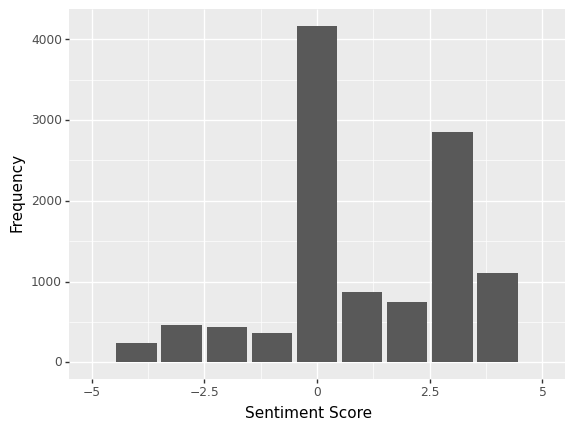

<ggplot: (8793183288342)>

In [33]:
(ggplot(df, aes(x='sentiment_score')) 
 + geom_bar() 
 + labs(x="Sentiment Score", y="Frequency") 
 + xlim(-5, 5)
)

### Overall sentiment using AFINN shows that game rarely gets below a nuetral (0) but also has just as many users with positive sentiment as nuetral


In [54]:
nuetral_reviews = df[df['sentiment_score']==0]
sample_nue_reviews = nuetral_reviews.sample(n=10)
for index, row in sample_nue_reviews.iterrows():
    print(f"Review: {row['review']}")
    print(f"Cleaned Review: {''.join(row['preprocessed_text'])}")
    print(f"Sentiment score: {row['sentiment_score']}\n")


Review: online hacking's a issue but other than that idk
Cleaned Review: ['idk', 'hackings', 'online', 'issue']
Sentiment score: 0.0

Review: its gta 5
Cleaned Review: ['gta']
Sentiment score: 0.0

Review: do i need to give a review XD
Cleaned Review: ['give', 'xd', 'review', 'need']
Sentiment score: 0.0

Review: its a game
Cleaned Review: ['game']
Sentiment score: 0.0

Review: gud
Cleaned Review: ['gud']
Sentiment score: 0.0

Review: ggggggggggg
Cleaned Review: ['ggggggggggg']
Sentiment score: 0.0

Review: HEY
Cleaned Review: ['hey']
Sentiment score: 0.0

Review: L.❤.V.E
Cleaned Review: ['lredheartve']
Sentiment score: 0.0

Review: dfgghg
Cleaned Review: ['dfgghg']
Sentiment score: 0.0

Review: oio
Cleaned Review: ['oio']
Sentiment score: 0.0



In [58]:
nuetral_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4164 entries, 9 to 13033
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommendationid   4164 non-null   int64  
 1   review             4164 non-null   object 
 2   timestamp_created  4164 non-null   int64  
 3   timestamp_updated  4164 non-null   int64  
 4   voted_up           4164 non-null   bool   
 5   votes_up           4164 non-null   int64  
 6   steamid            4164 non-null   int64  
 7   playtime_forever   4164 non-null   int64  
 8   last_played        4164 non-null   object 
 9   preprocessed_text  4164 non-null   object 
 10  sentiment_score    4164 non-null   float64
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 361.9+ KB


In [55]:
negative_reviews = df[df['sentiment_score'] < 0]
sample_neg_reviews = negative_reviews.sample(n=10)
for index, row in sample_neg_reviews.iterrows():
    print(f"Review: {row['review']}")
    print(f"Cleaned Review: {''.join(row['preprocessed_text'])}")
    print(f"Sentiment score: {row['sentiment_score']}\n")

Review: Online is full of hackers and cheaters, do not even bother trying lol
Cleaned Review: ['cheater', 'trying', 'even', 'bother', 'hacker', 'lol', 'full', 'online']
Sentiment score: -2.0

Review: it makes the deppression go away or makes it worse
Cleaned Review: ['deppression', 'away', 'make', 'go', 'worse']
Sentiment score: -3.0

Review: killing valet and not buying shark cards
Cleaned Review: ['shark', 'valet', 'buying', 'card', 'killing']
Sentiment score: -3.0

Review: A disappointment compared to their previous works. An option to buy in game cash for real money should never exist in an mmo. The game costs sixty dollars, why give them more money for a piss poor product.

Incredibly inconsistent bugs, errors, that will never be fixed. Basically I paid sixty dollars for an incomplete alpha game.
Cleaned Review: ['incomplete', 'work', 'sixty', 'option', 'inconsistent', 'piss', 'poor', 'cost', 'give', 'previous', 'money', 'fixed', 'real', 'dollar', 'paid', 'game', 'never', 'exist',

In [56]:
negative_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 1 to 13030
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommendationid   2051 non-null   int64  
 1   review             2051 non-null   object 
 2   timestamp_created  2051 non-null   int64  
 3   timestamp_updated  2051 non-null   int64  
 4   voted_up           2051 non-null   bool   
 5   votes_up           2051 non-null   int64  
 6   steamid            2051 non-null   int64  
 7   playtime_forever   2051 non-null   int64  
 8   last_played        2051 non-null   object 
 9   preprocessed_text  2051 non-null   object 
 10  sentiment_score    2051 non-null   float64
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 178.3+ KB


In [44]:
positive_reviews = df[df['sentiment_score']>0]
sample_pos_reviews = positive_reviews.sample(n=10)
for index, row in sample_pos_reviews.iterrows():
    print(f"Review: {row['review']}")
    print(f"Cleaned Review: {''.join(row['preprocessed_text'])}")
    print(f"Sentiment score: {row['sentiment_score']}\n")

Review: yes
Cleaned Review: ['yes']
Sentiment score: 1.0

Review: I am a 45 yo father, probably one of the oldest people playing this game. I am a single farther to my Son, who is 14 now. My son got this game for Christmas in 2021 from his uncle, so we installed it on his computer and he started playing. By the end of the week he had 24 hours on this game. This was horrible for me, as it was already hard for me to find ways to spend time with my son, as he is always out with his friends or just watching YouTube. So I decided to make a Steam account and get this game to see if I could maybe play alongside him. I loaded into the game, picked my character and started playing but I was stuck on what you where supposed to do. I asked my Son for help and he hosted a game for me to join. I loved it as it was the best time I had spent with my Son since my wife had died. This game has ever since brought me and my son closer again and now we actually spend time together outside the house togethe

In [57]:
positive_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6820 entries, 0 to 13034
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommendationid   6820 non-null   int64  
 1   review             6820 non-null   object 
 2   timestamp_created  6820 non-null   int64  
 3   timestamp_updated  6820 non-null   int64  
 4   voted_up           6820 non-null   bool   
 5   votes_up           6820 non-null   int64  
 6   steamid            6820 non-null   int64  
 7   playtime_forever   6820 non-null   int64  
 8   last_played        6820 non-null   object 
 9   preprocessed_text  6820 non-null   object 
 10  sentiment_score    6820 non-null   float64
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 592.8+ KB


### SentiWordNet

In [37]:
swn_words = [word[0] for row in df['preprocessed_text'] for word in row]
synsets = swn.senti_synsets('good', 'a')  # 'a' indicates that the word is an adjective
pos_score = neg_score = obj_score = 0

In [38]:
for syn in synsets:
    pos_score += syn.pos_score()
    neg_score += syn.neg_score()
    obj_score += syn.obj_score()

if len(list(synsets)) >0:
    pos_score /= len(synsets)
    neg_score /= len(synsets)
    obj_score /= len(synsets)
print(f"Positive score: {pos_score:.2f}, Negative score: {neg_score:.2f}, Objective score: {obj_score:.2f}") #Retirating what previously seen, overall postive from all collected

Positive score: 13.00, Negative score: 0.12, Objective score: 7.88


In [87]:
preprocessed_docs = [doc.split() for doc in df['preprocessed_text']]
dictionary = corpora.Dictionary(preprocessed_docs)
corpus = [dictionary.doc2bow(text) for text in preprocessed_docs]
texts = [eval(text) for text in df['preprocessed_text']]
coherence_dict = gensim.corpora.Dictionary(texts)
num_topics = 10

In [88]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=42,
                                            passes=20,
                                            per_word_topics=True)

In [89]:
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx}')
    keywords = "".join(word for word, _ in lda_model.show_topic(idx, topn=10))
    print(f'Top Keywords: {keywords}\n')


Topic: 0
Top Keywords: 'story']['love']['many','mode',['hi']'money']['like']['mode',['work','v']

Topic: 1
Top Keywords: ['game',['fun']'best']'love']'gud']'bad']'cool']'one','loved',['e']

Topic: 2
Top Keywords: 'played']'shit']'hate','shit','die','crime','forever',['literally','achievement',['lost',

Topic: 3
Top Keywords: 'game','rockstar','play']'get','mod',['nice']'account','dont','hacker','got',

Topic: 4
Top Keywords: 'game','online','gta','fun','time','get','play']'good','like','mode',

Topic: 5
Top Keywords: ['yes']'ever']['fun','best',['ok']['w']'played',['great']['recommend','killing']

Topic: 6
Top Keywords: ['good']'pretty']['u','fuck']['gg']'make']'cool',['gay',['guess',['amazing']

Topic: 7
Top Keywords: ['good','game']'game',['great',['nice','gta']['fun',['much',['amazing',['get',

Topic: 8
Top Keywords: 'game','good','fun','best']'play']['like','online']'gta',['gta','great',

Topic: 9
Top Keywords: ['gta']'life','rich','grind','watch','much','graphic','big','worth','fo

In [85]:
coherence_model = CoherenceModel(
    model=lda_model,
    texts=df['review'].tolist(),
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

/Users/los/opt/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
/Users/los/opt/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
/Users/los/opt/anaconda3/lib/python3.9/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide


Coherence Score: nan


In [60]:
positive_reviews.loc[positive_reviews['voted_up']==True]

,recommendationid,review,timestamp_created,timestamp_updated,voted_up,votes_up,steamid,playtime_forever,last_played,preprocessed_text,sentiment_score
0,134420493,very fun game to play with your friends,1678472945,1678472945,True,0,76561198449880601,28692,2023-03-10 13:27:19,"['fun', 'game', 'friend', 'play']",5.0
2,134415676,It's fun.,1678467049,1678467049,True,0,76561199164783545,12915,2023-02-09 01:42:35,['fun'],4.0
3,134413916,"Its GTA 5 ! \nWhats there to say, Its awesome",1678464935,1678464935,True,0,76561198255277604,19630,2023-03-10 13:50:37,"['whats', 'say', 'awesome', 'gta']",4.0
5,134403082,GOOD\n,1678453972,1678453972,True,0,76561198124027104,28492,2023-03-10 10:06:59,['good'],3.0
6,134397418,love this game,1678445275,1678445275,True,0,76561198863303361,19843,2023-03-10 07:54:45,"['game', 'love']",3.0
...,...,...,...,...,...,...,...,...,...,...,...
13025,117940209,Story Mode - Solid yes\n\nGTA Online - 6 / 10...,1656608547,1672536237,True,0,76561198008275738,21740,2023-03-08 22:19:08,"['repetitive', 'wont', 'heist', 'chinese', 'ch...",7.0
13027,117937397,so good\n,1656605485,1656605485,True,0,76561199241128647,24900,2023-01-31 18:13:38,['good'],3.0
13029,117936660,I think i have played a bit to much but its a ...,1656604751,1656604751,True,0,76561198880002773,78022,2022-07-12 08:06:22,"['much', 'great', 'game', 'bit', 'think', 'pla...",3.0
13032,117931745,yes,1656599722,1656599722,True,0,76561199230184990,30760,2023-02-28 19:20:06,['yes'],1.0


In [65]:
#Train/Test Split target being sentiment score
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_text'], df['sentiment_score'], test_size=0.2, random_state=42)


In [71]:
#Vectorize the text data using the bag-of-words representation
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

### Logistic Regression

In [69]:
model = LogisticRegression()
model.fit(X_train_vect, y_train)

/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [72]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = model.predict(X_test_vect)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))


Accuracy: 0.6743383199079401
Precision: 0.6135102736319294
Recall: 0.6743383199079401
F1 score: 0.6383641001708866


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### CNN Model 

In [1]:
num_classes = 3
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=max_seq_len))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64, callbacks=callbacks)

# Evaluate model on test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'Sequential' is not defined